In [1]:
# expand cells to the 95% of the display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

# Automatic rule-based modeling of the *Escherichia coli* Gene Regulatory Network of the RNA Polymerase and Sigma Factors

Authors: Rodrigo Santibáñez[1,2], Daniel Garrido[2], and Alberto Martín[1]

Date: September 2020

Affiliations:
1. Centro de Genómica y Bioinformática, Facultad de Ciencias, Universidad Mayor, Santiago, 8580745, Chile.
2. Department of Chemical and Bioprocess Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Santiago, 7820436, Chile

Notes: This tutorial was created for the manuscript "*Atlas*: Automatic modeling of regulation of bacterial gene expression and metabolism using rule-based languages", first submitted for peer-review to Bioinformatics on May, 2020.

## Prerequisites

0. The tutorial was prepared and executed on Ubuntu 20.04, PathwayTools version 24, and docker engine version 19.03.8.<br/><br/>

1. PathwayTools must be installed and running to obtain data from the EcoCyc database. Please, run ```pathway-tools -lisp -python-local-only``` before to obtain any data.<br/>
   (Optional) The PathwayTools software could be executed in the background, with help of ```nohup pathway-tools -lisp -python-local-only > /dev/null 2> /dev/null &```.<br/>
   Please follow instructions at http://pathwaytools.org/ to obtain a licensed copy of the software from https://biocyc.org/download-bundle.shtml. However, data could be manually formatted using a text-based editor or a spreadsheet software.
   
   Note: If you ran into the ```pathway-tools/aic-export/pathway-tools/ptools/22.5/exe/aclssl.so: undefined symbol: CRYPTO_set_locking_callback``` error, please follow instructions here: https://github.com/networkbiolab/atlas/tree/master/PTools-Docker. Instructions will guide you to install a docker image that is able to run pathway tools, but does not include it, so you still need to obtain the software with a valid license.<br/><br/>
   
2. (Highly recommended) Install Docker. Please follow instructions for a supported Operating System https://docs.docker.com/engine/install/:<br/>
   On Ubuntu, install it with ```apt-get install docker.io```.<br/>
   On Win10, install Docker Desktop with WSL2 support https://docs.docker.com/docker-for-windows/wsl/.<br/>
   On MacOS, install Docker Desktop https://docs.docker.com/docker-for-mac/install/.<br/><br/>
   The Docker ```networkbiolab/pleiades```installs the python packages, the jupyter server, and the stochastic simulators.<br/><br/>

3. (Recommended) Jupyter notebook. We recommend the use of Anaconda3 https://www.anaconda.com/products/individual because of the easier installation of the stochastic simulators from https://anaconda.org/alubbock.<br/><br/>

4. (Optional) A stochastic simulator, supported by the pySB python package ([BNG2](https://github.com/RuleWorld/bionetgen), [NFsim](https://github.com/ruleworld/nfsim/tree/9178d44455f6e27a81f398074eeaafb2a1a4b4bd), [KaSim](https://github.com/Kappa-Dev/KappaTools) or [Stochkit](https://github.com/StochSS/StochKit)). pySB requires BNG2 to simulate models with NFsim.<br/><br/>

5. (Optional) Cytoscape to visualize metabolic networks and others.

## Preamble: load *Atlas*

In [2]:
# testing source code
import sys
sys.path.append("../../..")

import atlas_rbm.atlas as atlas
import atlas_rbm.utils as utils
import atlas_rbm.export as export
import atlas_rbm.simulation as simulation

## Modeling

In [3]:
%time model1 = atlas.construct_model_from_interaction_network('../input_networks/network-ProtProt.txt')
model1

CPU times: user 1.55 s, sys: 32.4 ms, total: 1.58 s
Wall time: 1.59 s


<Model 'atlas_rbm.construct_model_from_interaction_network' (monomers: 1, rules: 10, parameters: 40, expressions: 0, compartments: 0) at 0x7f0cb1e200a0>

In [4]:
%time model2 = atlas.construct_model_from_sigma_specificity_network(promoters = '../input_networks/network-sigma-specificity.txt', architecture = 'rpoD-network-operon-arq.txt')
model2

CPU times: user 4 s, sys: 7.91 ms, total: 4.01 s
Wall time: 4.04 s


<Model 'atlas_rbm.construct_model_from_sigma_specificity_network' (monomers: 4, rules: 112, parameters: 178, expressions: 0, compartments: 0) at 0x7f0d0e6e4e20>

In [5]:
%time combined = atlas.combine_models([model1, model2])
combined

CPU times: user 4.62 s, sys: 12.1 ms, total: 4.63 s
Wall time: 4.7 s


<Model 'atlas_rbm.atlas' (monomers: 4, rules: 122, parameters: 208, expressions: 0, compartments: 0) at 0x7f0cb1c254f0>

To simulate, we need to set the initial condition:

In [6]:
# initial condition
# proteins
simulation.set_initial.prot(combined, 'rpoA', 'cyt', 56) # 2 copies per edge in the GRN
simulation.set_initial.prot(combined, 'rpoB', 'cyt', 28)
simulation.set_initial.prot(combined, 'rpoC', 'cyt', 28)
simulation.set_initial.prot(combined, 'rpoD', 'cyt', 0)
simulation.set_initial.prot(combined, 'rpoE', 'cyt', 4)
simulation.set_initial.prot(combined, 'rpoH', 'cyt', 2)
simulation.set_initial.prot(combined, 'rpoN', 'cyt', 3)
simulation.set_initial.prot(combined, 'rpoS', 'cyt', 7)
simulation.set_initial.prot(combined, 'fliA', 'cyt', 3)
simulation.set_initial.prot(combined, 'fecI', 'cyt', 0)

# genes
simulation.set_initial.dna(combined, 'rpoA', 1)
simulation.set_initial.dna(combined, 'rpoBrpoC', 1)
simulation.set_initial.dna(combined, 'rpoD', 1)
simulation.set_initial.dna(combined, 'rpoE', 1)
simulation.set_initial.dna(combined, 'rpoH', 1)
simulation.set_initial.dna(combined, 'rpoN', 1)
simulation.set_initial.dna(combined, 'rpoS', 1)
simulation.set_initial.dna(combined, 'fliA', 1)
simulation.set_initial.dna(combined, 'fecI', 1)

<Model 'atlas_rbm.atlas' (monomers: 4, rules: 122, parameters: 208, expressions: 0, compartments: 0) at 0x7f0cb1c254f0>

In [7]:
export.to_kappa(combined, 'model_rpoD.kappa')

In [8]:
# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'

# %time data1 = simulation.scipy(combined, start = 0, finish = 10, points = 500)
%time data2 = simulation.kasim(combined, start = 0, finish = 100, points = 100, n_runs = 100, path = kasim)

CPU times: user 3.31 s, sys: 774 ms, total: 4.08 s
Wall time: 4min 32s


Finally, we plot the simulation results. The result of the ```simulation.ode()``` function is a pandas dataframe. In the case of stochastic simulations (SSA, KaSim, NFsim, Stochkit), the function returns a dictionary with a list of dataframe for each simulations (```sims``` key), and dataframe with the average (```avrg``` key) and a dataframe with the standard deviation (```stdv``` key) of those simulations. Currently, we included three kind of plots, although the user could access the dataframes and plot diretly with methods in the seaborn package (https://seaborn.pydata.org/), in the pandas package (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), or with matplotlib (https://matplotlib.org/).

In [9]:
import seaborn
import matplotlib.pyplot as plt

for key in [
#     'figure.titlesize',
    'font.size',
#     'legend.fontsize',
#     'legend.title_fontsize',
    'font.size', 
#     'xtick.labelsize',
    'xtick.major.size',
    'xtick.minor.size',
#     'ytick.labelsize',
    'ytick.major.size',
    'ytick.minor.size']:
    plt.rcParams[key] = plt.rcParams[key] * 1.1

palette = seaborn.color_palette('colorblind')

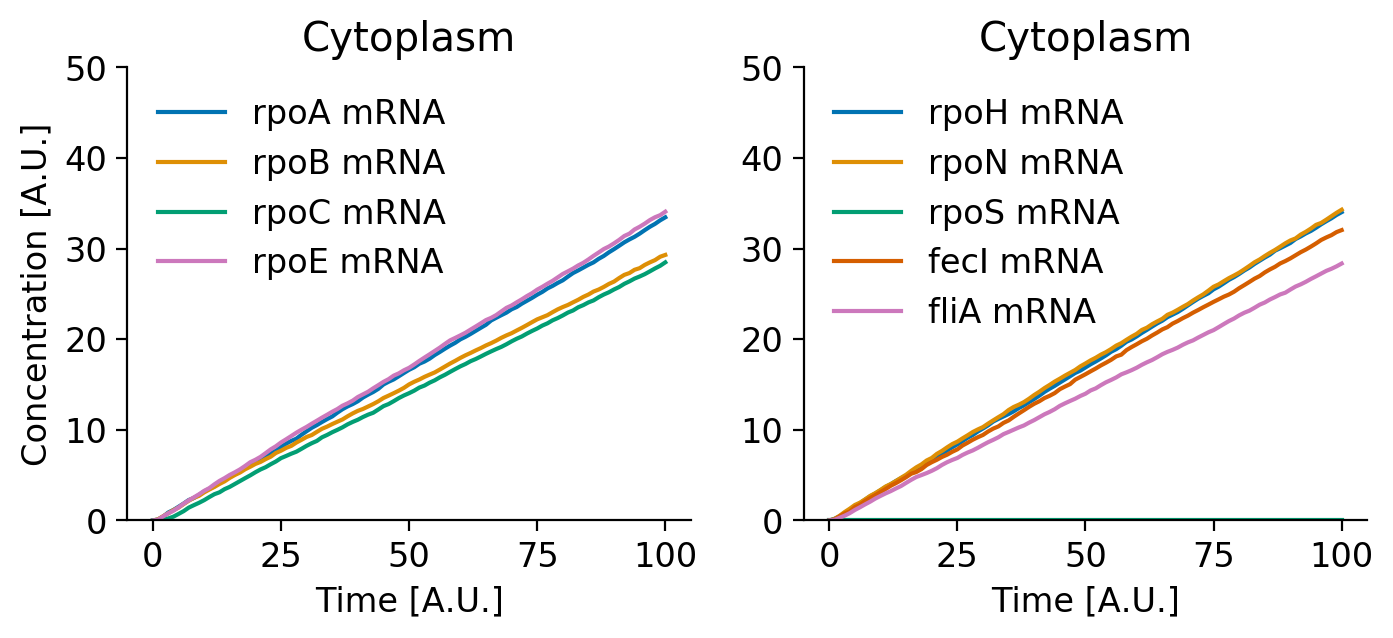

In [10]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 200)

# first plot
simulation.plot.rna(data2['avrg'], 'rpoA_CDS', ax = ax[0], plt_kws = {'color' : palette[0], 'label' : r'rpoA mRNA'})
simulation.plot.rna(data2['avrg'], 'rpoB_CDS', ax = ax[0], plt_kws = {'color' : palette[1], 'label' : r'rpoB mRNA'})
simulation.plot.rna(data2['avrg'], 'rpoC_CDS', ax = ax[0], plt_kws = {'color' : palette[2], 'label' : r'rpoC mRNA'})
# simulation.plot.rna(data2['avrg'], 'rpoD_CDS', ax = ax[0], plt_kws = {'color' : palette[3], 'label' : r'rpoD mRNA'})
simulation.plot.rna(data2['avrg'], 'rpoE_CDS', ax = ax[0], plt_kws = {'color' : palette[4], 'label' : r'rpoE mRNA'})

# second plot
simulation.plot.rna(data2['avrg'], 'rpoH_CDS', ax = ax[1], plt_kws = {'color' : palette[0], 'label' : r'rpoH mRNA'})
simulation.plot.rna(data2['avrg'], 'rpoN_CDS', ax = ax[1], plt_kws = {'color' : palette[1], 'label' : r'rpoN mRNA'})
simulation.plot.rna(data2['avrg'], 'rpoS_CDS', ax = ax[1], plt_kws = {'color' : palette[2], 'label' : r'rpoS mRNA'})
simulation.plot.rna(data2['avrg'], 'fecI_CDS', ax = ax[1], plt_kws = {'color' : palette[3], 'label' : r'fecI mRNA'})
simulation.plot.rna(data2['avrg'], 'fliA_CDS', ax = ax[1], plt_kws = {'color' : palette[4], 'label' : r'fliA mRNA'})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 50, bottom = 0)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Cytoplasm')
ax[1].set_ylim(top = 50, bottom = 0)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)

seaborn.despine()
plt.savefig('figure_rpoD_avrg.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_rpoD_avrg.png', format = 'png', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_rpoD_avrg.jpg', format = 'jpg', bbox_inches = 'tight', dpi = 300)

plt.show()

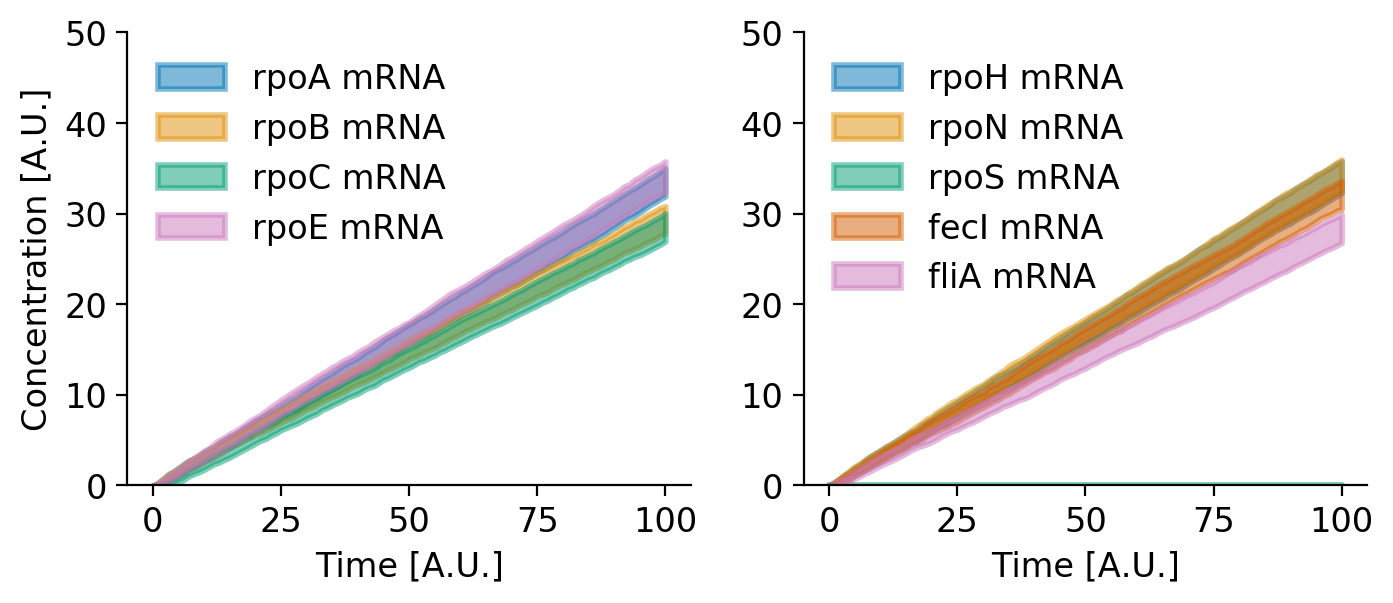

In [11]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 200)

# first plot
simulation.plot.rna(
    data2, 'rpoA_CDS', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5, 'label' : r'rpoA mRNA'})
simulation.plot.rna(
    data2, 'rpoB_CDS', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5, 'label' : r'rpoB mRNA'})
simulation.plot.rna(
    data2, 'rpoC_CDS', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[2], 'alpha' : .5, 'label' : r'rpoC mRNA'})
# simulation.plot.rna(
#     data2, 'rpoD_CDS', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
#     plt_kws = {'s' : 2, 'color' : palette[3], 'alpha' : .5, 'label' : r'rpoD mRNA'})
simulation.plot.rna(
    data2, 'rpoE_CDS', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[4], 'alpha' : .5, 'label' : r'rpoE mRNA'})

# second plot
simulation.plot.rna(
    data2, 'rpoH_CDS', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5, 'label' : r'rpoH mRNA'})
simulation.plot.rna(
    data2, 'rpoN_CDS', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5, 'label' : r'rpoN mRNA'})
simulation.plot.rna(
    data2, 'rpoS_CDS', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[2], 'alpha' : .5, 'label' : r'rpoS mRNA'})
simulation.plot.rna(
    data2, 'fecI_CDS', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[3], 'alpha' : .5, 'label' : r'fecI mRNA'})
simulation.plot.rna(
    data2, 'fliA_CDS', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[4], 'alpha' : .5, 'label' : r'fliA mRNA'})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_ylim(top = 50, bottom = 0)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_ylim(top = 50, bottom = 0)

ax[0].legend(frameon = False, loc = 'upper left')
ax[1].legend(frameon = False, loc = 'upper left')

seaborn.despine()
plt.savefig('figure_rpoD.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_rpoD.png', format = 'png', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_rpoD.jpg', format = 'jpg', bbox_inches = 'tight', dpi = 300)

plt.show()

In [12]:
export.to_kappa(combined, 'rpoD.kappa')